Imports

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

Frames loading et création du DataFrame

In [38]:
base_dir = "./data/chest_Xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


def create_dataframe_from_pneumonia_directory(directory):
    file_paths = []
    labels = []
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.startswith(".") or "Zone.Identifier" in img_name:
                continue
            img_path = os.path.join(class_dir, img_name)
            file_paths.append(img_path)
            labels.append(0 if class_name == "NORMAL" else 1)  # 0: NORMAL, 1: PNEUMONIA
    return pd.DataFrame({"file_path": file_paths, "label": labels})


train_df = create_dataframe_from_pneumonia_directory(train_dir)
val_df = create_dataframe_from_pneumonia_directory(val_dir)
test_df = create_dataframe_from_pneumonia_directory(test_dir)

print("Train:", train_df["label"].value_counts())
print("Val:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

Train: label
1    3875
0    1341
Name: count, dtype: int64
Val: label
0    8
1    8
Name: count, dtype: int64
Test: label
1    390
0    234
Name: count, dtype: int64


Split -> Pas besoin car nos dossiers étaient déjà triés par train/test/val.

A la place on mettra en place la validation croisée

Charger les images (On a précédemment chargé les images et créé un DataFrame,  mais pour faire un PCA, standardiser et faire un KNN il ne faut pas des chemins de fichiers mais des vecteurs)

In [ ]:
trainval_df = pd.concat([train_df, val_df], ignore_index=True)

def load_images(df, image_size=(64, 64)): # Passer en 64x64 ce qui réduira largement la vitesse de traitement
    images = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(row["file_path"], cv2.IMREAD_GRAYSCALE) # Passer en niveaux de gris
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img.flatten())
            labels.append(row["label"])
    return np.array(images), np.array(labels)


X_trainval, y_trainval = load_images(trainval_df)

Standardiser (ce qui consiste à centrer et réduire les données pour qu'elles aient une moyenne de 0 et un écart-type de 1)

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_trainval)

PCA pour réduire la dimensionnalité

In [41]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

Classification KNN

In [42]:
knn = KNeighborsClassifier(n_neighbors=5)

Validation croisée

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(knn, X_pca, y_trainval, cv=cv, scoring="accuracy")

print(f"Accuracy moyenne : {np.mean(scores):.4f}")
print(f"Scores de chaque fold : {scores}")

Accuracy moyenne : 0.9507
Scores de chaque fold : [0.94746896 0.95319962 0.95028681 0.94837476 0.9541109 ]


In [44]:
for n in [0.95, 50, 100, 150, 200, 300, 500]:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    scores = cross_val_score(knn, X_pca, y_trainval, cv=cv, scoring="accuracy")
    print(f"n_components={n}, Accuracy moyenne : {np.mean(scores):.4f}")

n_components=0.95, Accuracy moyenne : 0.9394
n_components=50, Accuracy moyenne : 0.9474
n_components=100, Accuracy moyenne : 0.9509
n_components=150, Accuracy moyenne : 0.9505
n_components=200, Accuracy moyenne : 0.9486
n_components=300, Accuracy moyenne : 0.9457
n_components=500, Accuracy moyenne : 0.9423


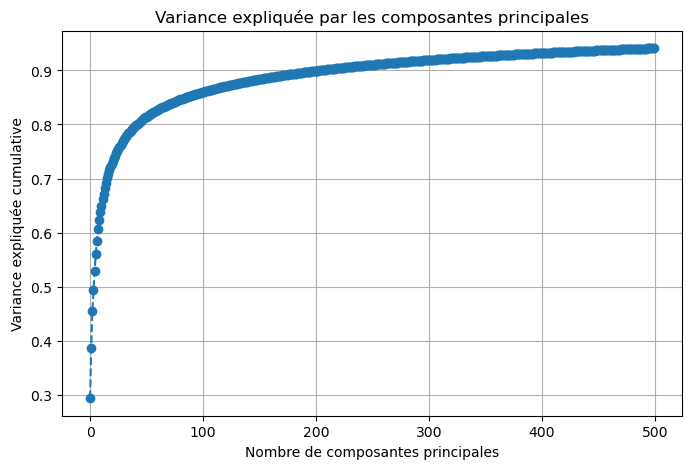

In [45]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulative")
plt.title("Variance expliquée par les composantes principales")
plt.grid()
plt.show()

In [46]:
pca_150 = PCA(n_components=150)
X_pca_150 = pca_150.fit_transform(X_scaled)
scores_150 = cross_val_score(knn, X_pca_150, y_trainval, cv=cv, scoring="accuracy")
print(f"Accuracy moyenne avec 150 composantes : {np.mean(scores_150):.4f}")

Accuracy moyenne avec 150 composantes : 0.9501
